# Predicting Functionality of Waterpoints in Tanzania

![img](images/lake_victoria.jpg)

(Lake Victoria in Tanzania - image courtesy of [thepinkbackpack.com](https://www.thepinkbackpack.com/).)

## Business Problem

**Business problem:** About 4 million of Tanzania's 59 million people lack access to potable (drinking) water; an even greater proportion of the Tanzanian population (nearly half) lack access to what water.org calls "[improved sanitation](https://water.org/our-impact/where-we-work/tanzania/)".

## Data

Data used in this classification project comes from an ongoing competition hosted by DrivenData, [*Pump it Up: Data Mining the Water Table*](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/). Descriptions of each column can be found at [this link](data_dict_basic.txt) within this repository.

In [20]:
# Packages for data cleaning, plotting, and manipulation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# scikit-learn libraries/functions/classes

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

In [21]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally;
# feel free to comment out if undesired
pd.set_option('display.max_columns', None)

### Initial Data Cleaning and Comprehension

In [22]:
# Importing training data
train_val = pd.read_csv('data/training_set_values.csv')

# Only using `status_group` column from label set, to
# avoid duplicating `id` column
train_label = pd.read_csv('data/training_set_labels.csv',
                             usecols = ['status_group'])


# Test set - not to be used until models have been trained,
# internally validated, etc.
test_df = pd.read_csv('data/test_set_values.csv')

In [23]:
# Concatenating separate .csv files
df = pd.concat(objs = [train_val, train_label],
               axis = 1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We have about **forty** potential features here, indicated by columns `0` through `39`; column `40`, `status_group`, is our target variable. The majority (30) of those columns  are currently stored as type `object`, the remainder as either `int64` or `float64`. Whether or not the numeric type columns contain continuous data will require further investigation.

In [25]:
# 59,400 rows of data in our training set
print(f'Train set: {df.shape[0]} rows')

# 14,850 rows of data in our test set
print(f'Test set: {test_df.shape[0]} rows')

Train set: 59400 rows
Test set: 14850 rows


In [29]:
# Checking for null values in features columns

df.isna().sum();

Columns/features with large numbers of **null values**, from least to greatest quantity:

- `subvillage` (371)
- `permit` (3056)
- `public_meeting` (3334)
- `funder` (3635)
- `installer` (3655)
- `scheme_management` (3877)
- `scheme_name` (28166) **(!)**

In [30]:
# Descriptive stats on numerical columns

df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Takeaways:
- `id` is purely an identifier - it's not going to be useful for modeling purposes.
- It's unlikely that `num_private` will be, either - we have a lot of data missing in this column (see the values for `min`, `25%`, `50%`, and `75%` in the descriptive statistics table), and the data dictionary has no articulation of what the values in this column actually indicate.
- `construction_year` has a `mean` heavily impacted by zero values; we'll need to handle this somehow.
- `gps_height`, `longitude`, and `latitude` are all numerical representations of location data.
- What unit is `population` in? We'll likely need to scale this; we also have a `max` value that's *well* above the `75%` value in that column.
    - The same applies for `amount_tsh`, which measures the total amount of water available to the waterpoint (the 'total static head')
- `region_code` and `district_code` look like discrete, categorical data.

#### Distribution of `y`

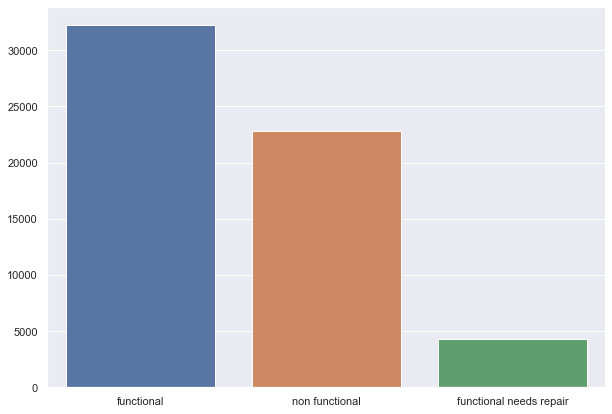

In [50]:
plt.figure(figsize=(10,7))

sns.set_theme()
sns.barplot(x = df.status_group.value_counts().index,
            y = df.status_group.value_counts().values);

### Value Counts for Potential Feature Selection

In [30]:
df.duplicated().value_counts()

False    59400
dtype: int64

No duplicate rows!

In [55]:
df.basin.value_counts();

In [54]:
df.construction_year.value_counts();

In [19]:
# Is it worth teasing out the difference between communal standpipe
# and communal standpipe multiple?

print(df['waterpoint_type'].value_counts())
print('')
print(df['waterpoint_type_group'].value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [20]:
# salty/fluoride also have 'abandoned' specs in the `water_quality`
# column that are collapsed in the `quality_group` column

print(df['water_quality'].value_counts())
print('')
print(df['quality_group'].value_counts())

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [50]:
# Checking datatypes of columns
df.dtypes;

In [58]:
# Dropping columns determined to be either irrelevant or
# superfluous in exploratory analysis

cols_to_drop = [
    'id',  # unique identifier, not useful for modeling
    'wpt_name',  # identifier column, not useful for modeling
    'quantity_group',  # identical information to `quantity`
    'num_private',  # data dict. does not provide details for this column
    'payment',  # identical information to `payment_type`
    'scheme_name',  # large number of nulls, redundant vis-a-vis `scheme_management`
    'extraction_type',
    'extraction_type_group'  # using `extraction_type_class` for generalized info
]

In [54]:
num_cols = None
cat_cols = None

## Preprocessing

### Train/Test Split and Initial Preparation for ML

In [7]:
# Splitting DataFrame into features/values DataFrame
# (i.e. `X`) and labels series (`y`)

X = df.drop('status_group', axis = 1)
y = df['status_group']

In [9]:
# Splitting internal training data into separate
# training and test sets for (eventual) internal validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 138)

### Pipelines: Scaling and Encoding

In [ ]:
# pipe = Pipeline(steps=[
#     ('ss', StandardScaler())
# ])

## Modeling

### Dummy Model

### Simple Model 1

### Simple Model 2

# Scrap Code

In [ ]:
# X.loc[X['funder'].isna()].head();